## 0. 라이브러리 불러오기

In [ ]:
import os
import platform
import math

import pandas as pd
import numpy as np
pd.set_option('max.columns', 1000)

import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# 서로 다른 운영체제를 사용하기 때문에 각 운영체제에 맞는 글씨체 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'AppleGothic'

import statsmodels.api as sm
from scipy import stats

from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, accuracy_score, silhouette_score, silhouette_samples

from yellowbrick.cluster import SilhouetteVisualizer

## 1. 데이터 불러오기

In [2]:
# 현재 경로를 저장
current_path = os.getcwd()

# 사용할 데이터가 저장되어 있는 경로를 저장
data_path = input('사용할 데이터가 저장되어 있는 경로를 입력해주세요 :')

사용할 데이터가 저장되어 있는 경로를 입력해주세요 : /Users/yangjaeyeong/Desktop/JOISS_해양과학/Data


In [8]:
# 데이터 불러오기
raw_coast_data = pd.read_csv(data_path + '/격자(4단계)_데이터최종결합_median.csv', encoding = 'CP949')

# '평균' 변수 제거
raw_coast_data = raw_coast_data.drop('평균', axis = 1)

# QGIS로 작업을 수행했기 때문에 변수명이 일부 잘리는 현상 발생
raw_coast_data.rename(columns = {'용존무기질' : '용존무기질소', '암모니아성' : '암모니아성 질소', '아질산성질' : '아질산성질소', '수소이온농' : '수소이온농도', '부유물질 ' : '부유물질 농도', '화학적산소' : '화학적산소 요구량'}, inplace = True)

# 데이터 일부 확인
print('Shape of Coast data :', raw_coast_data.shape, '\n')
print(raw_coast_data.info(), '\n')
display(raw_coast_data.head())

Shape of Coast data : (1399, 31) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1399 non-null   int64  
 1   수온         1399 non-null   float64
 2   염분         1399 non-null   float64
 3   용존무기질소     1399 non-null   float64
 4   암모니아성 질소   1399 non-null   float64
 5   아질산성질소     1399 non-null   float64
 6   수소이온농도     1399 non-null   float64
 7   부유물질 농도    1399 non-null   float64
 8   규산염        1399 non-null   float64
 9   화학적산소 요구량  1399 non-null   float64
 10  투명도        1399 non-null   float64
 11  질소         1399 non-null   float64
 12  질산성질소      1399 non-null   float64
 13  인산염인       1399 non-null   float64
 14  클로로필       1399 non-null   float64
 15  용존산소       1399 non-null   float64
 16  총인         1399 non-null   float64
 17  자갈         1399 non-null   float64
 18  모래         1399 non-null   float64
 19  실트         13

,id,수온,염분,용존무기질소,암모니아성 질소,아질산성질소,수소이온농도,부유물질 농도,규산염,화학적산소 요구량,투명도,질소,질산성질소,인산염인,클로로필,용존산소,총인,자갈,모래,실트,점토,분급,IL,AVS,TOC,출현 종수,서식밀도,생체량,다양도,ISEP,target
0,316,26.545904,32.266284,66.109781,14.322414,6.973147,8.971842,11.729158,304.898470,1.932255,2.790482,272.399140,44.816863,9.331492,4.020105,8.383000,27.493661,2.131936,21.012963,53.767258,23.087646,2.241080,3.900139,0.012845,0.575763,13,1073,150.545300,1.715788,4.175382,0
1,317,26.555080,32.312201,64.474075,14.593281,6.735420,9.020974,11.715535,305.709195,1.920633,2.876308,269.995185,43.151896,9.239086,4.006589,8.381494,27.350137,2.388136,22.438908,52.496485,22.697930,2.224635,3.867279,0.012892,0.568869,13,1100,146.906715,1.707911,4.207599,0
2,401,24.010903,31.337345,27.902231,12.518333,2.279968,8.153232,7.047915,158.576875,1.820178,2.495793,200.074455,13.180409,7.248091,5.254767,8.494714,21.724608,0.564265,55.127657,35.540126,8.770322,1.634023,2.947883,0.006344,0.383511,13,1047,314.910615,1.745795,4.040487,0
3,402,24.195079,31.393658,42.311762,19.336271,3.228646,8.144855,7.970248,201.319945,1.867706,2.524248,217.344345,19.809824,9.458643,5.185926,8.302811,25.360672,0.541554,53.524824,36.376906,9.480037,1.744004,3.112902,0.007427,0.408045,13,1051,338.006930,1.776740,3.981114,0
4,403,24.317078,31.425321,58.525447,27.159785,4.254249,8.137352,9.072605,253.782260,1.937710,2.545189,237.580635,27.159875,12.054842,5.129125,8.086393,29.792724,0.550979,53.523564,35.998440,9.931874,1.816959,3.226403,0.008408,0.424802,14,1072,365.213195,1.810976,3.902928,0


## 2. Target 변수 확인

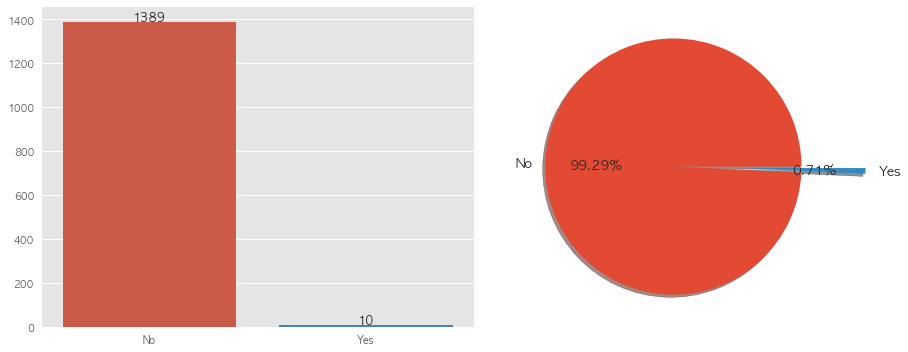

In [9]:
# Target 데이터 확인
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# Countplot
sns.countplot(x = 'target', data = raw_coast_data, ax = axes[0])
axes[0].set_xticklabels(labels = ['No', 'Yes'])

for rect in axes[0].patches:
    axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = 'center', fontsize = 12)

# Pie Chart
plot_data = raw_coast_data['target'].value_counts()
plot_data.plot.pie(explode = [0, 0.5], shadow = True, labels = ['No', 'Yes'], fontsize = 13, autopct = '%.2f%%', ax = axes[1])
    
for index in [0, 1]:
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')

fig.tight_layout()

- 1,399개의 격자에서 갯끈풀이 발생한 격자는 **10**개로, 전체 데이터 중에서 **0.71**%를 차지한다.


- 위의 결과를 통해, 현재 데이터에 불균형이 존재함을 확인할 수 있으므로 오버샘플링을 수행해주도록 한다.

## 3. EDA(Exploratory Data Analysis) - 1

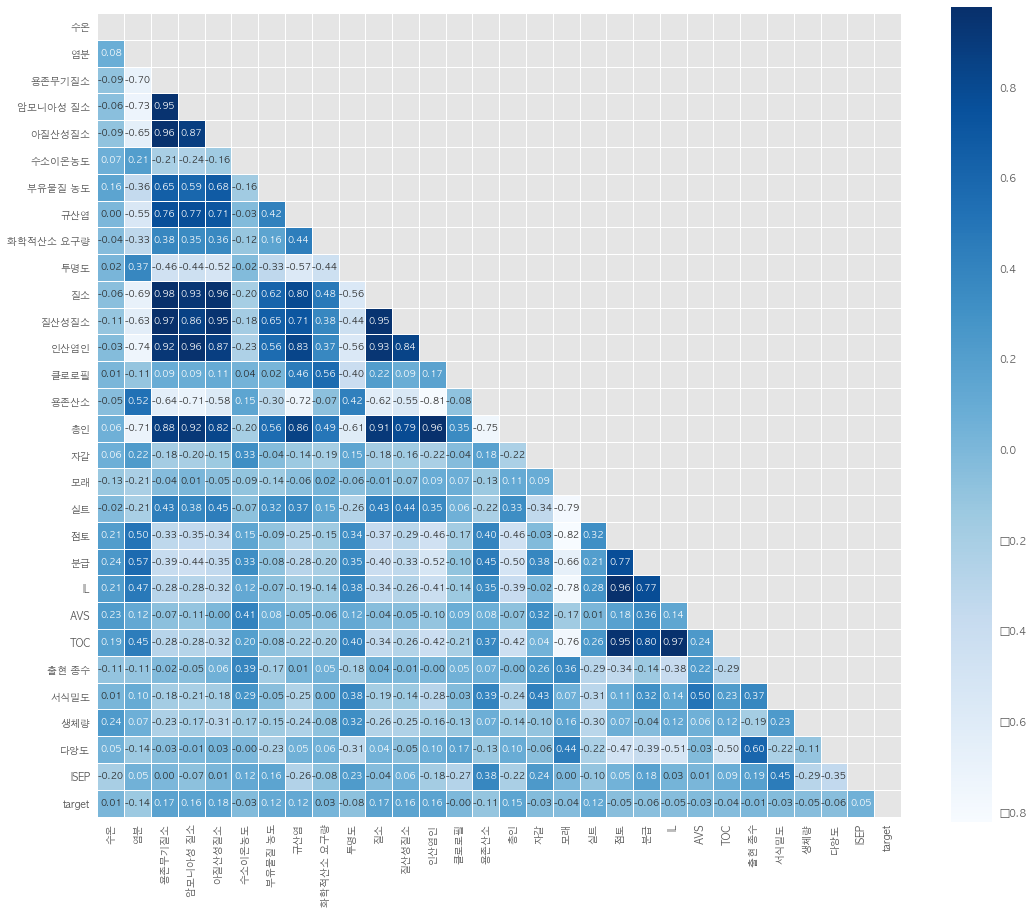

In [10]:
cor_data = raw_coast_data.drop(['id'], axis = 1).corr()

# Heatamp 옵션 생성
mask = np.zeros_like(cor_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Heatmap
plt.figure(figsize = (18, 15))

sns.heatmap(cor_data, mask = mask, square = True, linewidths = 0.5, cmap = 'Blues', fmt = '.2f', annot = True, annot_kws = {'fontsize' : 9})
plt.show()

- Target 값을 단순히 수치형으로 생각하고, 히트맵을 살펴보면 모든 변수와의 상관계수가 낮음을 확인할 수 있다.

- 독립변수간의 상관계수가 높은 값들이 관측되므로, 서로 상관계수가 높은 변수들을 처리해주어야 한다.

In [12]:
# 독립변수의 분포를 확인하고 종속변수와의 Boxplot을 시각화해주는 함수 생성
def stat_visual_analysis(indepen_value = None, depen_value = None, data = None):
    
    # 왜도, 첨도 구하기
    skew_value = np.round(stats.skew(data[indepen_value]), 4)
    kurt_value = np.round(stats.kurtosis(data[indepen_value]), 4)
    
    print('{} 변수의 왜도 :'.format(indepen_value), skew_value, '\n')
    print('{} 변수의 첨도 :'.format(indepen_value), kurt_value, '\n')
    
    # 해당 변수의 IQR 방법을 사용하여 이상치 확인하기
    Q1 = np.quantile(data[indepen_value], 0.25)
    Q3 = np.quantile(data[indepen_value], 0.75)
    
    # 1.5 가중치를 사용하여 계산
    IQR = Q3 - Q1
    IQR_weight = IQR * 1.5
    
    upper_value = Q3 + IQR_weight
    lower_value = Q1 - IQR_weight
    
    outlier_count = data[(data[indepen_value] < lower_value) | (data[indepen_value] > upper_value)].shape[0]
    print('{} 변수의 이상치 개수 :'.format(indepen_value), outlier_count, '\n')
    
    # 시각화 과정
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
    
    # 독립변수의 Histogram 시각화
    sns.histplot(x = indepen_value, stat = 'density', data = data, ax = axes[0])
    sns.kdeplot(x = indepen_value, color = 'orange', linestyle = '--', linewidth = 5, data = data, ax = axes[0])
    
    # 독립변수의 Boxplot 시각화
    sns.boxplot(x = indepen_value, data = data, ax = axes[1])
    sns.swarmplot(x = indepen_value, alpha = 0.3, data = data, ax = axes[1])
    axes[1].axvline(upper_value, color = 'green', linewidth = 4, alpha = 0.5, linestyle = '--')
    axes[1].axvline(lower_value, color = 'green', linewidth = 4, alpha = 0.5, linestyle = '--')
    
    # 종속변수와의 Boxplot 시각화
    sns.boxplot(x = depen_value, y = indepen_value, data = data, ax = axes[2])
    sns.swarmplot(x = depen_value, y = indepen_value, alpha = 0.5, data = data, ax = axes[2])
    axes[2].set_xticklabels(['No', 'Yes'])
    
    for index in [0, 1, 2]:
        axes[index].set_title('{}'.format(indepen_value), fontsize = 12)
        axes[index].set_xlabel('')
        axes[index].set_ylabel('')
    
    fig.tight_layout()

### 3.1 수온 - X

수온 변수의 왜도 : -0.9856 

수온 변수의 첨도 : 1.7005 

수온 변수의 이상치 개수 : 93 



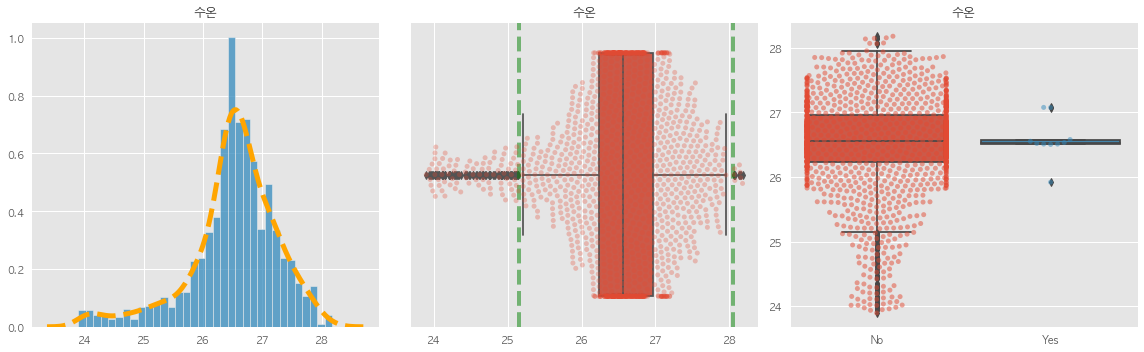

In [13]:
stat_visual_analysis(indepen_value = '수온', depen_value = 'target', data = raw_coast_data)

- 수온 변수에는 **93**개의 이상치가 존재하며, 수온은 갯끈풀에 큰 영향을 미치지 않는 것으로 판단된다.

### 3.2 염분 - O

염분 변수의 왜도 : -2.3453 

염분 변수의 첨도 : 8.0809 

염분 변수의 이상치 개수 : 62 



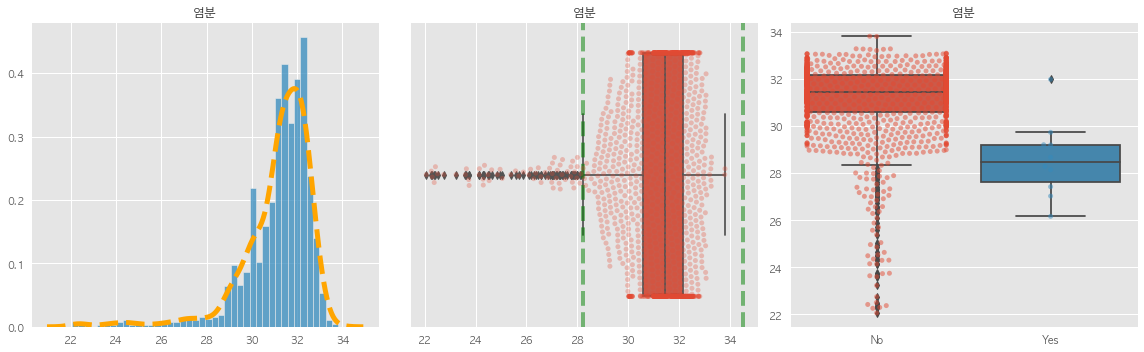

In [14]:
stat_visual_analysis(indepen_value = '염분', depen_value = 'target', data = raw_coast_data)

- 염분 변수에는 62개의 이상치가 존재하며, 염분은 갯끈풀에 영향을 미치는 것으로 판단된다.

- **미기록 외래잡초 영국갯끈풀의 국내 분포와 식물학적 특성**의 논문을 살펴보면, 습하고 염도가 높은 환경을 선호한다고 했으나, 현재 데이터로 보았을 때는 너무 높은 염도에서는 발견되지 않음을 확인할 수 있다.

### 3.3 질소 변수 - [용존무기질소, 암모니아성 질소, 아질산성 질소, 질산성 질소, 질소]

- [JOISS 화학해양 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)


- [Naver - Total Nitrogen](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=k0ks0&logNo=221405525369)

- 총 질소(Total Nitrogen)는 물 속에 포함된 질소화합물(유기성 질소, 암모니아성 질소, 아질산성 및 질살성 질소) 등의 총량을 의미한다.


- 총 질소는 자연계의 질소순환과정에서 자연수에 포함되어 있으나, 생활하수, 공장폐수, 축산폐수 등과 같은 인위적은 유입에 따라 증가한다고 한다.


- 즉, 하천이나 바다로 다량 유입될 경우 부영양화, 적조, 수중의 용존산소결핍 등을 야기시킨다.


- 여기서 무기성질소는 암모니아성 질소, 질산성 질소, 아질산성 질소의 합이며, 유기성 질소는 분해가 되는 경우 암모니아성 질소의 형태로 되기 때문에 총 질소는 실질적으로 무기성 질소를 나타내는 것이 된다고 한다.

In [15]:
# 질소 관련 변수 일부 확인
raw_coast_data[['질소', '용존무기질소', '암모니아성 질소', '아질산성질소', '질산성질소']].head()

,질소,용존무기질소,암모니아성 질소,아질산성질소,질산성질소
0,272.399140,66.109781,14.322414,6.973147,44.816863
1,269.995185,64.474075,14.593281,6.735420,43.151896
2,200.074455,27.902231,12.518333,2.279968,13.180409
3,217.344345,42.311762,19.336271,3.228646,19.809824
4,237.580635,58.525447,27.159785,4.254249,27.159875


- 위 5개의 변수가 비슷한 의미를 나타내며, (암모니아성, 아질산성, 질산성)의 합이 무기질소를 나타내기 때문에, **질소** 혹은 **용존무기질소** 두 변수 중에서 하나의 변수를 사용하는 것이 적절하다고 판단된다.

용존무기질소 변수의 왜도 : 2.2217 

용존무기질소 변수의 첨도 : 4.7115 

용존무기질소 변수의 이상치 개수 : 258 



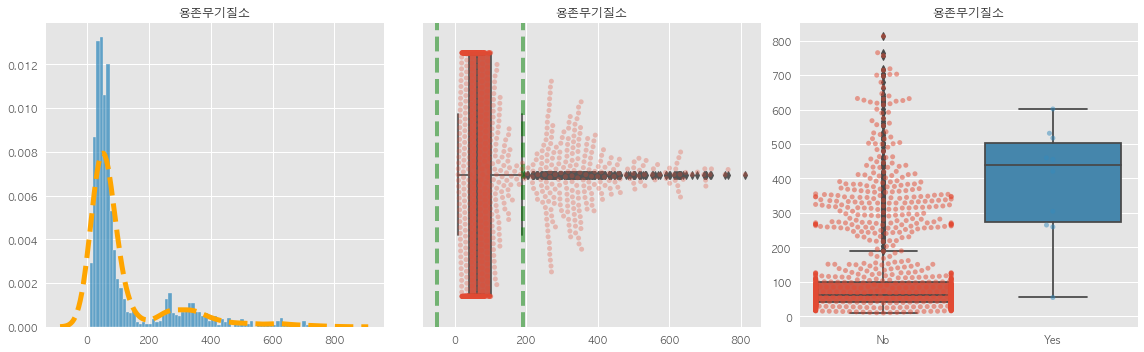

In [16]:
# 용존무기질소 변수 확인
stat_visual_analysis(indepen_value = '용존무기질소', depen_value = 'target', data = raw_coast_data)

질소 변수의 왜도 : 1.9021 

질소 변수의 첨도 : 3.2269 

질소 변수의 이상치 개수 : 249 



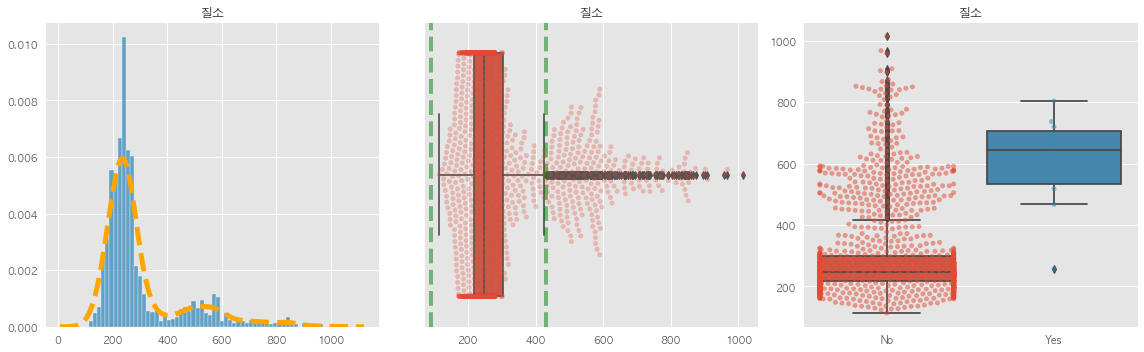

In [17]:
# 총 질소를 나타내는 '질소' 변수 확인
stat_visual_analysis(indepen_value = '질소', depen_value = 'target', data = raw_coast_data)

- 두 변수 분포가 비슷하나 **질소** 변수의 왜도와 첨도가 더 낮으므로 **질소** 변수를 사용하도록 하자.


- 또한, 갯끈풀 발생 지역이 질소가 높은 것으로 보아, 갯끈풀이 발생한 지역은 환경적으로 좋지 않다는 것을 알 수 있다.

### 3.4 수소이온농도 - 구간화

- [Naver - 지식백과](https://terms.naver.com/entry.naver?docId=5145248&cid=61234&categoryId=61234)


- [해양산성화와 해양생태계](file:///C:/Users/KCG/Downloads/%ED%95%B4%EC%96%91%EC%82%B0%EC%84%B1%ED%99%94%EC%99%80%20%ED%95%B4%EC%96%91%EC%83%9D%ED%83%9C%EA%B3%84_%EB%B6%84%EC%84%9D%EB%B3%B4%EA%B3%A0%EC%84%9C_%EA%B9%80%EC%A3%BC%EC%98%81.pdf)

- 수소이온농도는 용액 1L 속에 존재하는 수소 이온의 몰수를 의미하며, 용액의 산성, 알칼리성의 정도를 나타내는 수치를 말한다.


- 수소이온농도가 급변하거나 장기간에 걸쳐 무르이 산성화를 유발하는 경우 인체, 환경 또는 주변서식 동식물에게 큰 영향을 미칠 수 있다.


- 해양산성화는 해수의 수소이온농도가 증가하는 현상을 의미하며, 수소이온농도가 증가하는 이유는 대기 중에 존재하는 이산화탄소가 바닷물에 녹아들기 때문이다.


- pH는 수소이온의 활성도를 표현하는 지수이며, 용액의 산성도를 평가하는데 활용된다. 또한, 범위는 0부터 14이다.


- 현재 데이터의 경우 IDW 기법을 사용하여 데이터를 보간했기 때문에 지정된 범위를 넘어서는 관측치가 발견된다.


- 따라서 동일하게 개수를 나눠 구간화를 수행해주도록 하자.

In [18]:
print('Shape of Coast data *Before Create* :', raw_coast_data.shape, '\n')

raw_coast_data['수소이온농도_구간'] = pd.qcut(raw_coast_data['수소이온농도'], 5, labels = ['구간1', '구간2', '구간3', '구간4', '구간5'])
print('Shape of Coast data *After Create* :', raw_coast_data.shape)

Shape of Coast data *Before Create* : (1399, 31) 

Shape of Coast data *After Create* : (1399, 32)


In [19]:
display(pd.crosstab(raw_coast_data['target'], raw_coast_data['수소이온농도_구간']))

수소이온농도_구간,구간1,구간2,구간3,구간4,구간5
target,,,,,
0,271,280,279,280,279
1,9,0,0,0,1


- 갯끈풍에 해당되는 지역이 매우 소수이기 때문에 뚜렷한 차이를 확인할 수 없지만, **구간1**에서 대부분 관측됨을 확인할 수 있다.

### 3.5 부유물질 농도 - O

- [부유물질이란?](https://airsafetytimes.tistory.com/43)


- [MyWater - 물백과사전](https://www.water.or.kr/encyclopedia/encyclopedia/encyclopediaview.do?seq=527&p_group_seq=526&menu_mode=4&currentPageNo=44&search_Hangulindex=%E3%85%82&search_Engindex=&TERM_SEQNO=2259&HANGULTERM=&ENGTERM=&COMM_CODE=&ATTFILE_SEQNO=&languege=h&searchTextBefor=&searchText=)

- 부유물질은 물에 용해되지 않으면서 입자 지금이 2mm 이하인 물속에서 부유하고 있는 물질을 일컫는 말로 오염된 물의 수질을 표시하는 지표이다.


- 하천 등 자연수역에 방류되면 물의 탁도를 높이고 외관을 더럽히며, 그 중 생물분해 가능한 유기물질은 용존산소를 감소시킨다.

부유물질 농도 변수의 왜도 : 2.5882 

부유물질 농도 변수의 첨도 : 9.5112 

부유물질 농도 변수의 이상치 개수 : 100 



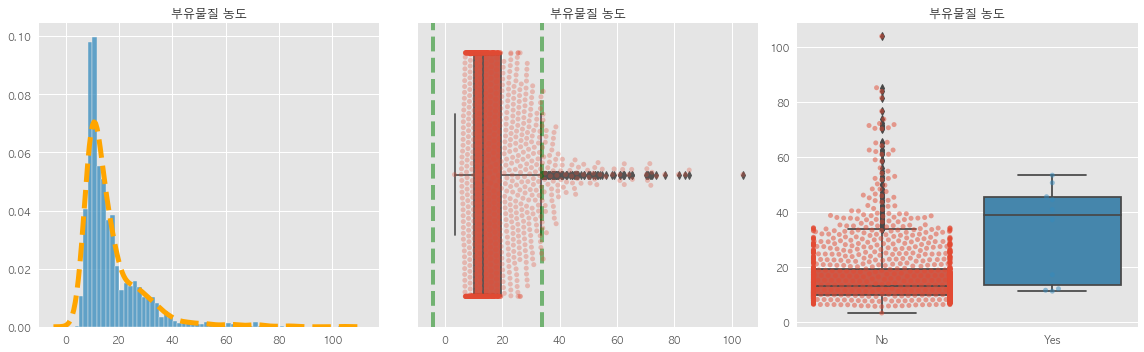

In [20]:
stat_visual_analysis(indepen_value = '부유물질 농도', depen_value = 'target', data = raw_coast_data)

- 부유물질 농도 변수에는 100개의 이상치가 존재하며, 갯끈풀 발생 지역의 부유물질 농도가 높음을 확인할 수 있다.


- 부유물질 농도는 갯끈풀에 영향을 미치는 것으로 판단된다.

### 3.6. 규산염 - O

- [위키백과 - 규산염](https://ko.wikipedia.org/wiki/%EA%B7%9C%EC%82%B0%EC%97%BC)

- 규산염은 조암 광물 중 가장 많은 양을 차지하는 광물로 규소와 산소 및 약간의 금속 원소로 이루어져 있다.

규산염 변수의 왜도 : 1.367 

규산염 변수의 첨도 : 1.7662 

규산염 변수의 이상치 개수 : 105 



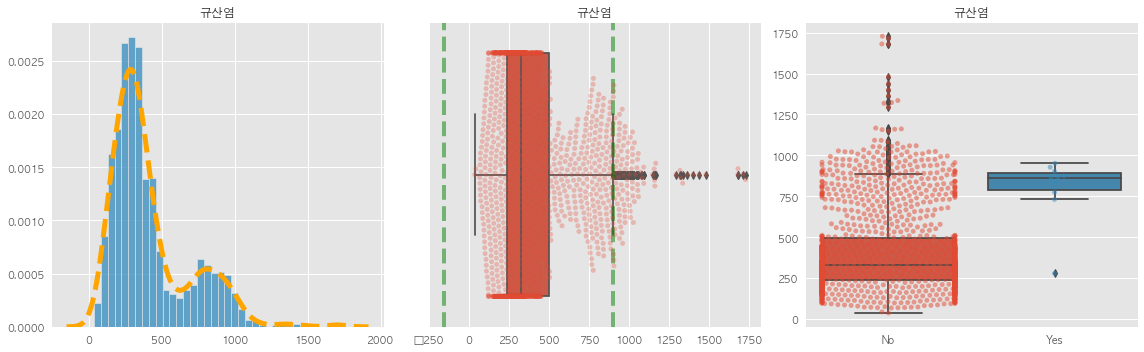

In [21]:
stat_visual_analysis(indepen_value = '규산염', depen_value = 'target', data = raw_coast_data)

- 규산염 변수에는 이상치가 105개 존재하며, 쌍봉형태를 나타내고 있다.


- 갯끈풀이 발생한 지역은 규산염이 많이 분포해 있음을 확인할 수 있다.

### 3.7 화학적산소 요구량 - O

- [JOISS 해양과학 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)

- 화학적산소요구량(Chemical Oxygen Demand, COD)은 화학적으로 분해 가능한 유기물을 산화제(시약)를 이용하여 산화시키는 데 필요한 산소의 양을 말한다.


- 즉, COD 값이 높으면 유기물이 많다는 것으로 그만큼 오염의 정도가 높은 것을 의미한다. (값이 클수록 수질오염이 심하다.)

화학적산소 요구량 변수의 왜도 : 1.0351 

화학적산소 요구량 변수의 첨도 : 2.9986 

화학적산소 요구량 변수의 이상치 개수 : 65 



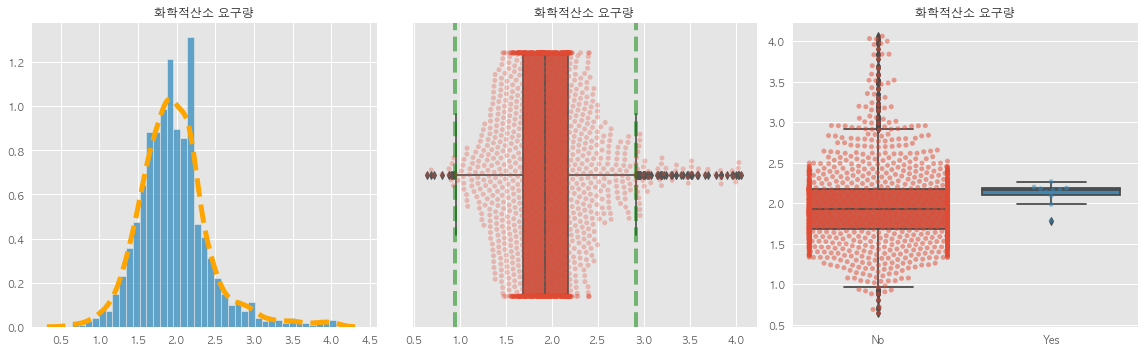

In [22]:
stat_visual_analysis(indepen_value = '화학적산소 요구량', depen_value = 'target', data = raw_coast_data)

- 화학적산소 요구량 변수는 정규분포에 가까움을 확인할 수 있으며, 이상치의 개수는 65개이다.


- 갯끈풀이 아닌 지역은 해당 변수의 분포가 전 범위에 걸쳐져 있지만, 갯끈풀이 발생한 지역은 어느정도 화학적산소 요구량이 높은것으로 보아 수질의 오염이 있다는 것을 확인할 수 있다.

### 3.8 투명도 - O

- [JOISS 해양과학 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)

- 투명도 즉, 물의 투명함 정도를 나타내는 것으로 투명도판이라 불리는 백색 원판을 수중에 넣어서 보이지 않는 데가지의 깊이를 미터로 표시한다.


- 물이 맑을수록 투명도가 높아진다.

투명도 변수의 왜도 : 1.5033 

투명도 변수의 첨도 : 2.8818 

투명도 변수의 이상치 개수 : 89 



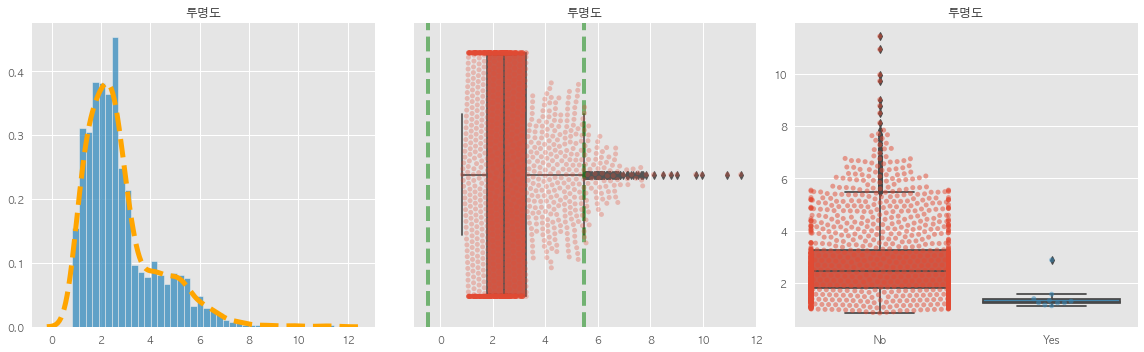

In [23]:
stat_visual_analysis(indepen_value = '투명도', depen_value = 'target', data = raw_coast_data)

- 갯끈풀이 발생한 지역의 투명도 값은 낮은 곳에 분포해 있음을 확인할 수 있으며, 물이 맑지 않다는 것을 확인할 수 있다.

### 3.9 인 변수 - [인산염인, 총인]

- [JOISS 해양과학 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)

- 총 인(Total Phosphorus)는 물 속에 포함된 인화합물(입자성 인, 유기성 인, 폴리인산염, 인산염이온 등)의 총 농도를 의미한다.


- 질소와 인은 주로 농업용 비료, 사람이나 가축의 분뇨, 합성세제로 부터 발생되며, 하천이나 바다로 다량 유입될 경우 부영양화, 적조, 수중의 용존산소결핍 등을 야기시킨다고 한다.


- 인산염인, 총인 두 개의 변수 분포를 확인 후 하나의 변수만 사용하도록 하자.

인산염인 변수의 왜도 : 1.547 

인산염인 변수의 첨도 : 1.335 

인산염인 변수의 이상치 개수 : 243 



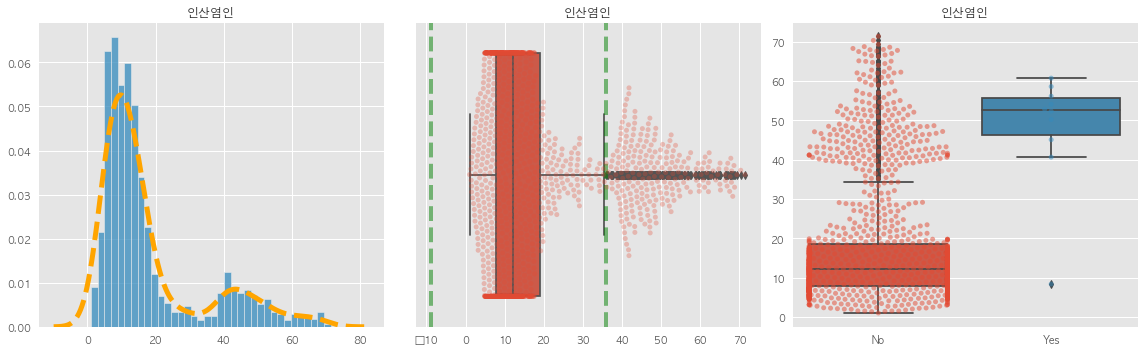

In [24]:
# 인산염인
stat_visual_analysis(indepen_value = '인산염인', depen_value = 'target', data = raw_coast_data)

총인 변수의 왜도 : 1.3629 

총인 변수의 첨도 : 1.0701 

총인 변수의 이상치 개수 : 121 



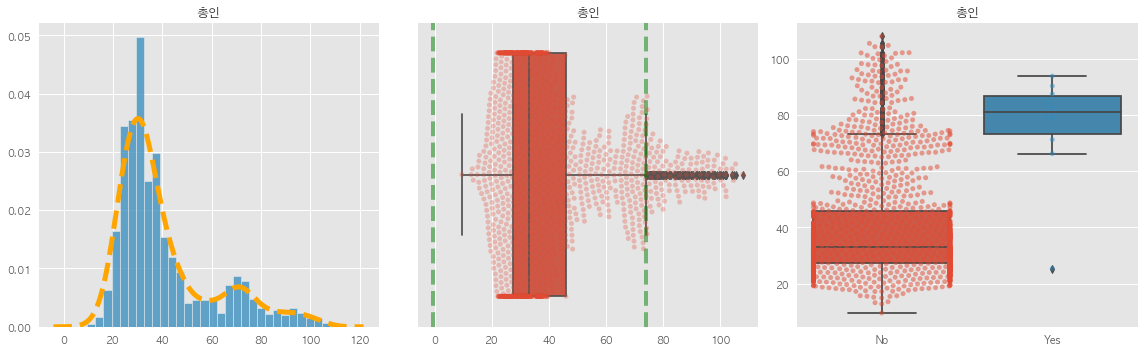

In [25]:
# 총인
stat_visual_analysis(indepen_value = '총인', depen_value = 'target', data = raw_coast_data)

- 인산염인과 총인 두 변수 모두 쌍봉형태를 나타내고 있음을 확인할 수 있다.


- 두 변수의 분포가 매우 비슷하지만, 총인 변수의 왜도와 첨도가 더 낮기 때문에 **총인** 변수를 사용해주도록 하자.

### 3.10 자갈 - O

자갈 변수의 왜도 : 3.2178 

자갈 변수의 첨도 : 15.9328 

자갈 변수의 이상치 개수 : 78 



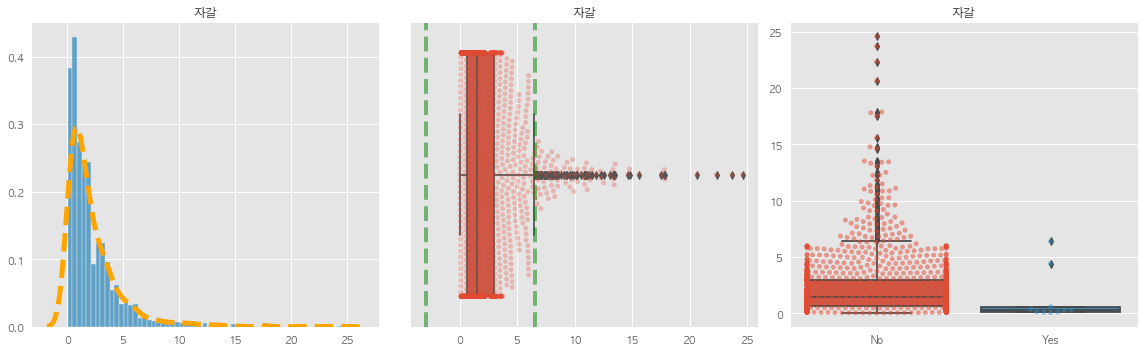

In [26]:
stat_visual_analysis(indepen_value = '자갈', depen_value = 'target', data = raw_coast_data)

- 자갈 변수의 경우 왼쪽으로 치우쳐져 있으며, 첨도가 매우 높음을 확인할 수 있다.


- 갯끈풀이 발생한 지역의 자갈 비율이 매우 작음을 확인할 수 있으며, 영향이 있는 것으로 판단된다.

### 3.11 모래, 실트, 점토 - 실트

- 실트는 모래보다 작고 점토보다 큰 토양입자이다.


- 모래, 실트, 점토 세 개의 변수가 비슷하기 때문에 세 변수의 분포 확인 후, 변수를 줄여주도록 하자.

모래 변수의 왜도 : 0.739 

모래 변수의 첨도 : 0.1374 

모래 변수의 이상치 개수 : 22 



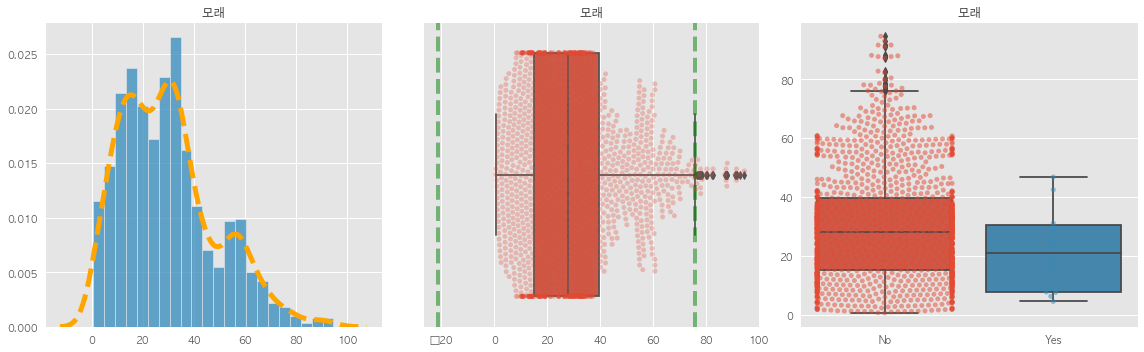

In [27]:
# 모래 변수 분포 확인
stat_visual_analysis(indepen_value = '모래', depen_value = 'target', data = raw_coast_data)

실트 변수의 왜도 : -0.4673 

실트 변수의 첨도 : 0.6909 

실트 변수의 이상치 개수 : 44 



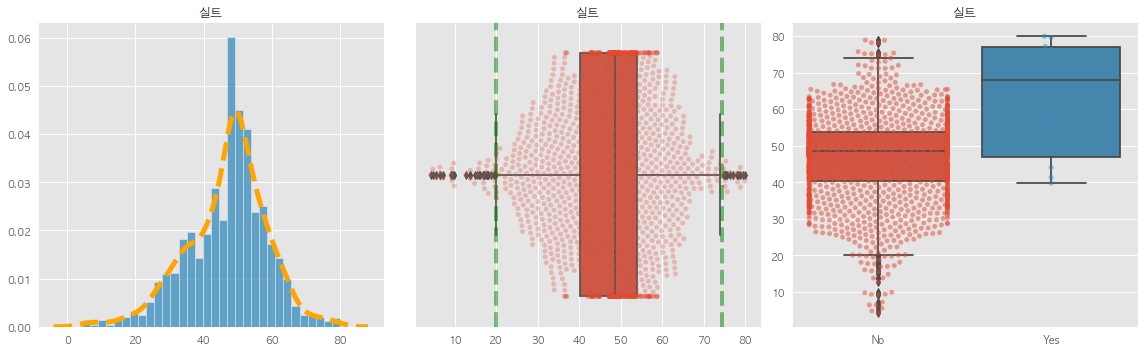

In [28]:
# 실트 변수 분포 확인
stat_visual_analysis(indepen_value = '실트', depen_value = 'target', data = raw_coast_data)

점토 변수의 왜도 : 0.3676 

점토 변수의 첨도 : -0.8298 

점토 변수의 이상치 개수 : 0 



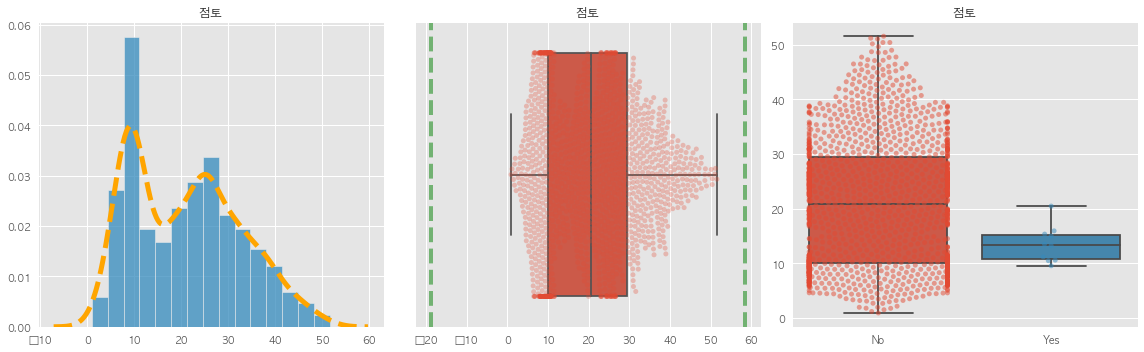

In [29]:
# 점토 변수 확인
stat_visual_analysis(indepen_value = '점토', depen_value = 'target', data = raw_coast_data)

- 세 변수 모두 왜도와 첨도가 낮고, 이상치가 매우 적거나 아예 없음을 확인할 수 있다.


- 세 변수 중에서 실트 변수가 가장 영향력이 있는 것으로 판단되기 때문에 **실트** 변수를 사용하도록 하자.

### 3.12 분급 - O

- [JOISS 해양과학 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)

- 퇴적물은 모래, 자갈 등 여러가지 크기의 입자가 섞여 있는데, 분급도는 퇴적물의 입자가 어느 정도 균일한지를 나타내는 척도이다.

분급 변수의 왜도 : -0.5409 

분급 변수의 첨도 : -0.3799 

분급 변수의 이상치 개수 : 0 



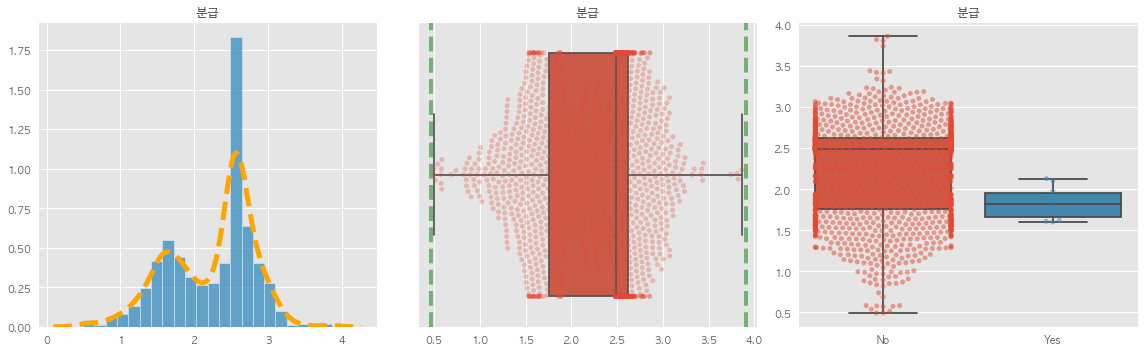

In [30]:
stat_visual_analysis(indepen_value = '분급', depen_value = 'target', data = raw_coast_data)

### 3.13 TOC - O

- [JOISS 해양과학 주요용어](https://joiss.kr/joiss/cont.edu.vocaList.do)


- https://kr.hach.com/parameters/toc

- 총 유기탄소(Total Organic Carbon)는 물 속 유기오염물질이 가진 탄소의 총량으로 수질오염 정도를 나타내는 주요 지표이다.


- 유기물은 강 또는 하천의 환경에 유독하며 물의 산소 수준을 대폭 감소시키고, 유기 폐기물은 어류를 질식시킬 수 있으며, 다른 여러 방식으로 수상 생테계에 영향을 끼칠 수 있다.

TOC 변수의 왜도 : 0.2984 

TOC 변수의 첨도 : -0.8576 

TOC 변수의 이상치 개수 : 0 



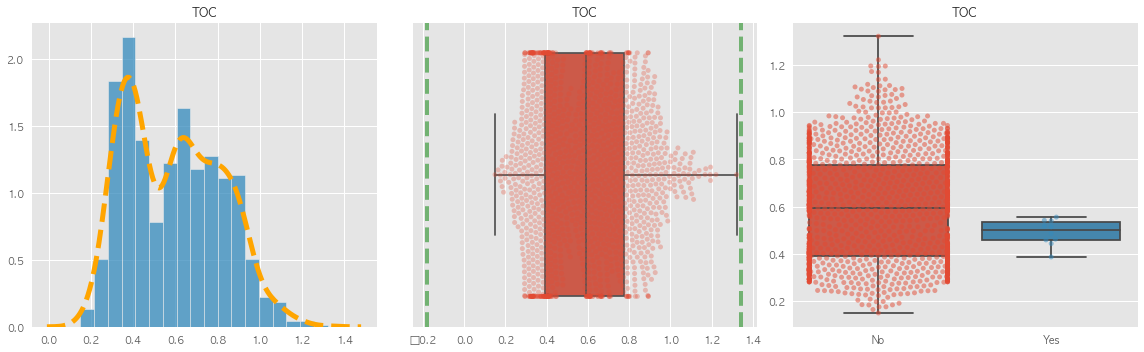

In [31]:
stat_visual_analysis(indepen_value = 'TOC', depen_value = 'target', data = raw_coast_data)

- 갯끈풀에 큰 영향을 주는것으로 보이지는 않지만 수질오염 정도를 나타내는 변수이기 때문에 추가하도록 한다.

### 3.14 출현 종수 - X

출현 종수 변수의 왜도 : 1.2425 

출현 종수 변수의 첨도 : 3.3702 

출현 종수 변수의 이상치 개수 : 71 



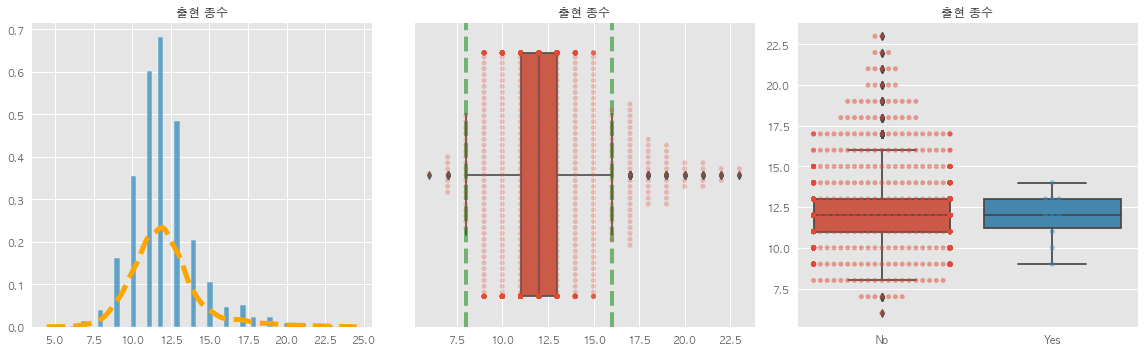

In [32]:
stat_visual_analysis(indepen_value = '출현 종수', depen_value = 'target', data = raw_coast_data)

- 출현 종수 변수는 이산형이며, 갯끈풀이 발생한 지역과 그렇지 않은 지역의 분포가 비슷함을 확인할 수 있다.


- 따라서 갯끈풀 발생에 영향을 미치지 않는 것으로 판단된다.

### 3.15 서식밀도 - X

서식밀도 변수의 왜도 : 3.761 

서식밀도 변수의 첨도 : 22.8841 

서식밀도 변수의 이상치 개수 : 124 



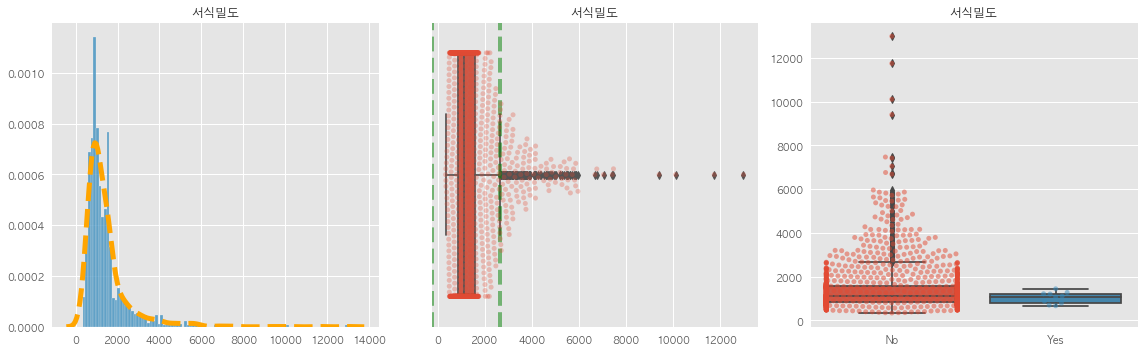

In [33]:
stat_visual_analysis(indepen_value = '서식밀도', depen_value = 'target', data = raw_coast_data)

- 서식밀도 변수의 경우 첨도가 매우 높음을 확인할 수 있다.


- 또한, 갯끈풀 발생에 영향을 미치지 않는 것으로 판단된다.

### 3.16 생체량 - 구간화

생체량 변수의 왜도 : 2.7988 

생체량 변수의 첨도 : 14.7916 

생체량 변수의 이상치 개수 : 30 



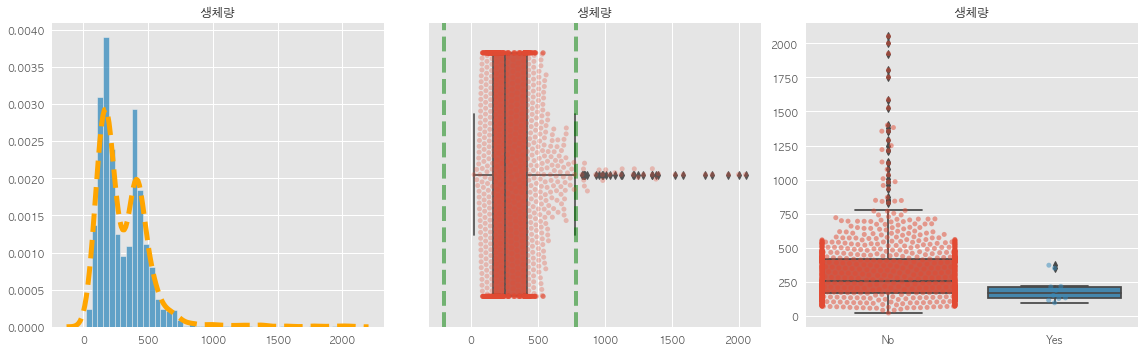

In [34]:
stat_visual_analysis(indepen_value = '생체량', depen_value = 'target', data = raw_coast_data)

- 생체량 변수의 경우 왼쪽으로 치우쳐져 있으며, 첨도가 매우 높음을 확인할 수 있다.


- 갯끈풀이 발생한 지역은 생체량이 낮은 곳에 분포해 있는것을 확인할 수 있다.


- 값의 범위가 너무 크기 때문에 구간화를 해서 살펴보도록 하자.

In [35]:
print('Shape of Coast data *Before Create* :', raw_coast_data.shape, '\n')

raw_coast_data['생체량_구간'] = pd.cut(raw_coast_data['생체량'], 6, labels = ['구간1', '구간2', '구간3', '구간4', '구간5', '구간6'])
print('Shape of Coast data *After Create* :', raw_coast_data.shape)

Shape of Coast data *Before Create* : (1399, 32) 

Shape of Coast data *After Create* : (1399, 33)


In [36]:
display(pd.crosstab(raw_coast_data['target'], raw_coast_data['생체량_구간']))

생체량_구간,구간1,구간2,구간3,구간4,구간5,구간6
target,,,,,,
0,851,493,27,9,4,5
1,9,1,0,0,0,0


### 3.17 다양도 - X

다양도 변수의 왜도 : 0.3143 

다양도 변수의 첨도 : 0.3699 

다양도 변수의 이상치 개수 : 14 



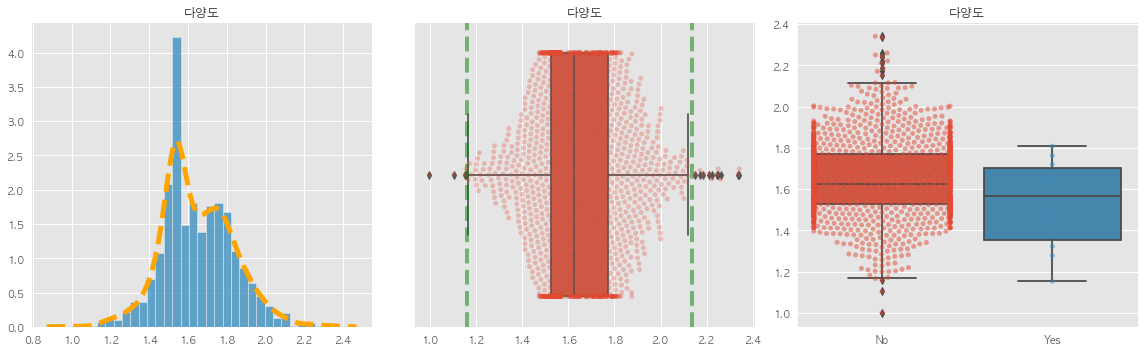

In [37]:
stat_visual_analysis(indepen_value = '다양도', depen_value = 'target', data = raw_coast_data)

- 다양도에 따라서는 큰 차이가 없는 것으로 보이기 때문에 제외해주도록 하자.

## 4. EDA(Exploratory Data Analysis) - 2

### 4.1 Correlation Analysis & PCA

In [38]:
# 분포 탐색을 통해 사용할 변수만 저장하여 데이터 생성
eda_data = raw_coast_data[['id', '염분', '질소', '수소이온농도_구간', '부유물질 농도', '규산염', '화학적산소 요구량', '투명도', '총인', '자갈', '실트', '분급', 'TOC', '생체량_구간', 'target']].copy()
display(eda_data.head())

,id,염분,질소,수소이온농도_구간,부유물질 농도,규산염,화학적산소 요구량,투명도,총인,자갈,실트,분급,TOC,생체량_구간,target
0,316,32.266284,272.399140,구간5,11.729158,304.898470,1.932255,2.790482,27.493661,2.131936,53.767258,2.241080,0.575763,구간1,0
1,317,32.312201,269.995185,구간5,11.715535,305.709195,1.920633,2.876308,27.350137,2.388136,52.496485,2.224635,0.568869,구간1,0
2,401,31.337345,200.074455,구간3,7.047915,158.576875,1.820178,2.495793,21.724608,0.564265,35.540126,1.634023,0.383511,구간1,0
3,402,31.393658,217.344345,구간2,7.970248,201.319945,1.867706,2.524248,25.360672,0.541554,36.376906,1.744004,0.408045,구간1,0
4,403,31.425321,237.580635,구간2,9.072605,253.782260,1.937710,2.545189,29.792724,0.550979,35.998440,1.816959,0.424802,구간2,0


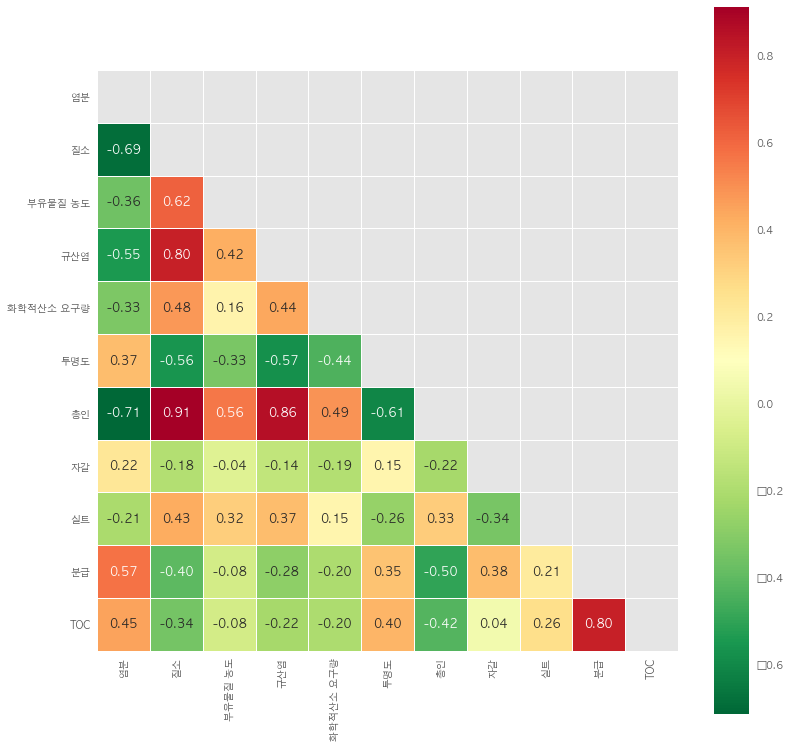

In [39]:
# 위에서 생성한 데이터를 가지고 다시 한번 히트맵을 그려보도록 하자.
cor_data = eda_data.drop(['id', 'target'], axis = 1).corr()

# 옵션 지정
mask = np.zeros_like(cor_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 시각화
plt.figure(figsize = (13, 13))
sns.heatmap(cor_data, mask = mask, square = True, linewidths = 0.5, cmap = 'RdYlGn_r', annot = True, fmt = '.2f', annot_kws = {'fontsize' : 12})
plt.show()

- 히트맵을 통해 서로 상관계수가 높은 변수가 있음을 확인할 수 있다.


- 위의 EDA를 통해 수질 오염과 관련된 **질소, 부유물질 농도, 규산염, 화학적산소 요구량, 투명도, 총인** 6개의 변수를 가지고 주성분분석(PCA)를 수행해보도록 하자.

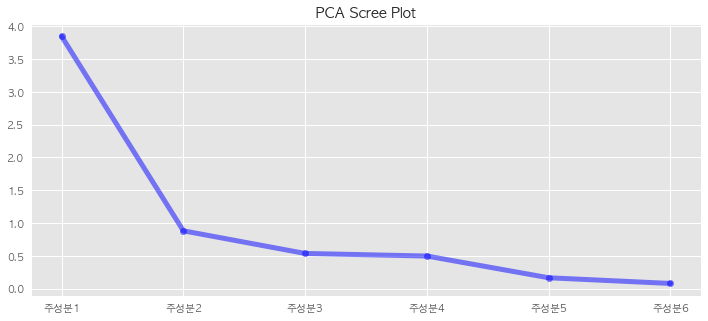

In [40]:
# 주성분분석을 수행할 데이터만 저장
pca_data = eda_data[['질소', '부유물질 농도', '규산염', '화학적산소 요구량', '투명도', '총인']]

# 주성분분석을 수행하기 위해서 모든 변수의 단위가 다르기 때문에 Scaling을 수행해주어야 한다.
scaler = StandardScaler()

# Scaling 수행
scaler_data = pd.DataFrame(scaler.fit_transform(pca_data), columns = pca_data.columns)

# PCA 객체 생성 후 학습
pca = PCA(random_state = 100)
pca.fit(scaler_data)

# 주성분 Scree Plot 
plt.figure(figsize = (12, 5))
plt.plot(pca.explained_variance_, marker = 'o', color = 'blue', alpha = 0.5, linewidth = 5)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5], labels = ['주성분1', '주성분2', '주성분3', '주성분4', '주성분5', '주성분6'])
plt.title('PCA Scree Plot');

- 주성분분석 수행 후 Scree Plot의 결과를 통해, 두 개의 주성분을 선택하는 것이 적절하다고 판단된다.

In [41]:
# 두 개의 주성분을 사용하여 데이터 생성하기
pca = PCA(n_components = 2, random_state = 100)
result_data = pd.DataFrame(pca.fit_transform(scaler_data), columns = ['오염_주성분1', '오염_주성분2'])

# 기존 6개의 변수를 삭제하고, 주성분분석 수행 결과로 생성된 두 개의 변수를 추가하기
eda_data = eda_data.drop(pca_data.columns, axis = 1)
eda_data = pd.concat([eda_data, result_data], axis = 1)
display(eda_data.head())

,id,염분,수소이온농도_구간,자갈,실트,분급,TOC,생체량_구간,target,오염_주성분1,오염_주성분2
0,316,32.266284,구간5,2.131936,53.767258,2.241080,0.575763,구간1,0,-0.792560,-0.319665
1,317,32.312201,구간5,2.388136,52.496485,2.224635,0.568869,구간1,0,-0.832183,-0.290755
2,401,31.337345,구간3,0.564265,35.540126,1.634023,0.383511,구간1,0,-1.546873,-0.558734
3,402,31.393658,구간2,0.541554,36.376906,1.744004,0.408045,구간1,0,-1.278618,-0.544470
4,403,31.425321,구간2,0.550979,35.998440,1.816959,0.424802,구간2,0,-0.942646,-0.549568


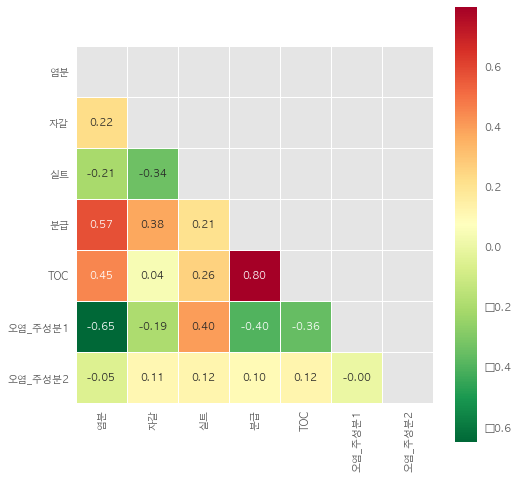

In [42]:
# 주성분분석 수행 후, 나온 결과를 합친 'eda_data'의 히트맵을 다시 시각화해보도록 하자.
cor_data = eda_data.drop(['id', 'target'], axis = 1).corr()

# 옵션 지정
mask = np.zeros_like(cor_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 시각화
plt.figure(figsize = (8, 8))
sns.heatmap(cor_data, mask = mask, square = True, linewidths = 0.5, cmap = 'RdYlGn_r', annot = True, fmt = '.2f', annot_kws = {'fontsize' : 10})
plt.show()

- 그 전의 히트맵 보다는 서로 상관계수가 높은 변수들이 적게 관측됨을 확인할 수 있다.


- 하지만, 여전히 상관계수가 높은 변수들이 관측되기 때문에 SMOTE 기법을 사용하여 오버샘플링 후, RandomForest 모델을 돌린다음 변수중요도를 살펴보도록 하자.

### 4.2 Model based variable selection

In [43]:
# 독립변수에 범주형 변수가 있기 때문에 SMOTENC 모델 객체 생성
smote = SMOTENC(categorical_features = [2, 7], random_state = 100)

# 오버샘플링 수행
X_resample, y_resample = smote.fit_sample(eda_data.drop('target', axis = 1), eda_data['target'])

# OverSampling 데이터 합치기
model_data = pd.concat([X_resample, y_resample], axis = 1).reset_index(drop = True)
display(model_data.head())

# 독립변수, 종속변수 나누기
X = model_data.drop(['id', 'target'], axis = 1)
y = model_data['target']

# 독립변수 중에서 연속형 변수는 Scaling 수행
scaler = StandardScaler()
X.loc[:,X.dtypes != 'category'] = scaler.fit_transform(X.loc[:,X.dtypes != 'category'])

# 독립변수에 범주형 변수가 있기 때문에 One-Hot Encoding
X = pd.get_dummies(X, drop_first = True)

,id,염분,수소이온농도_구간,자갈,실트,분급,TOC,생체량_구간,오염_주성분1,오염_주성분2,target
0,316,32.266284,구간5,2.131936,53.767258,2.241080,0.575763,구간1,-0.792560,-0.319665,0
1,317,32.312201,구간5,2.388136,52.496485,2.224635,0.568869,구간1,-0.832183,-0.290755,0
2,401,31.337345,구간3,0.564265,35.540126,1.634023,0.383511,구간1,-1.546873,-0.558734,0
3,402,31.393658,구간2,0.541554,36.376906,1.744004,0.408045,구간1,-1.278618,-0.544470,0
4,403,31.425321,구간2,0.550979,35.998440,1.816959,0.424802,구간2,-0.942646,-0.549568,0


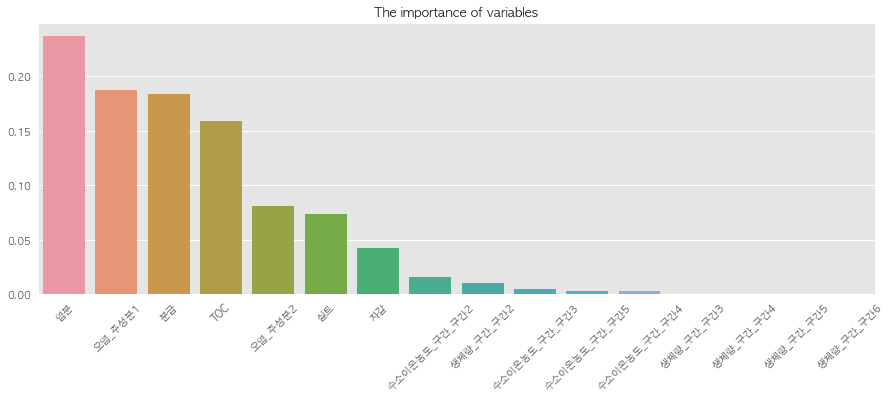

In [53]:
# Random Forest 모델 객체 생성
rf_model = RandomForestClassifier(random_state = 100)

# 생성한 모델로 학습
rf_model.fit(X, y)

# 변수중요도 정보를 담은 데이터 생성
importance_data = pd.DataFrame(rf_model.feature_importances_, index = X.columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

# 시각화 수행
plt.figure(figsize = (15, 5))
sns.barplot(x = importance_data.index, y = 'Importance', data = importance_data)
plt.xticks(rotation = 45)
plt.ylabel('')
plt.title('The importance of variables', fontsize = 13)
plt.show()

- 위의 그림을 통해 각 변수의 중요도를 확인할 수 있으며, 범주화를 수행해주었던 변수들은 모두 중요도가 낮음을 확인할 수 있다.


- 위의 히트맵 그림에서 **분급**과 **TOC** 변수가 상관계수가 높음을 확인할 수 있었는데, **분급** 변수의 중요도가 더 높기 때문에 **분급** 변수를 사용하도록 하자.


- 최종적으로 사용할 변수는 **염분, 분급, 실트, 자갈, 오염_주성분1, 오염_주성분2** 총 6개이다.

## 5. Modeling

In [54]:
# 최종적으로 사용할 변수를 선택하여 저장
final_data = eda_data[['id', '염분', '분급', '실트', '자갈', '오염_주성분1', '오염_주성분2', 'target']].copy()
print('Shape of final data :', final_data.shape, '\n')
display(final_data.head())

Shape of final data : (1399, 8) 



,id,염분,분급,실트,자갈,오염_주성분1,오염_주성분2,target
0,316,32.266284,2.241080,53.767258,2.131936,-0.792560,-0.319665,0
1,317,32.312201,2.224635,52.496485,2.388136,-0.832183,-0.290755,0
2,401,31.337345,1.634023,35.540126,0.564265,-1.546873,-0.558734,0
3,402,31.393658,1.744004,36.376906,0.541554,-1.278618,-0.544470,0
4,403,31.425321,1.816959,35.998440,0.550979,-0.942646,-0.549568,0


In [55]:
print('Before OverSampling, the shape of X :', final_data.drop(['id', 'target'], axis = 1).shape, '\n')
print('Before OverSampling, the shapd of y :', final_data['target'].shape, '\n')

# 데이터 불균형으로 인해 SMOTE 모델 객체 생성하여 오버샘플링
smote = SMOTE(random_state = 100)

# Over Sampling
X_resample, y_resample = smote.fit_sample(final_data.drop(['id', 'target'], axis = 1), final_data['target'])

print('After OverSampling, the shape of X :', X_resample.shape, '\n')
print('After OverSampling, the shapd of y :', y_resample.shape)

Before OverSampling, the shape of X : (1399, 6) 

Before OverSampling, the shapd of y : (1399,) 

After OverSampling, the shape of X : (2778, 6) 

After OverSampling, the shapd of y : (2778,)


In [56]:
# 변수의 중요도를 파악하기 위해 독립변수 정규화
scaler = StandardScaler()

# 주성분 변수를 제외하고 정규화 수행
X_resample.iloc[:, :-2] = scaler.fit_transform(X_resample.iloc[:, :-2])

# 7:3의 비율로 Train, Test 나누기
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size = 0.3, random_state = 100)

# 로지스틱 회귀분석 모델 객체 생성 후 학습
clf_model = sm.Logit(y_train, X_train).fit()
display(clf_model.summary())

Optimization terminated successfully.
         Current function value: 0.378926
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1944
Model:                          Logit   Df Residuals:                     1938
Method:                           MLE   Df Model:                            5
Date:                Sat, 23 Oct 2021   Pseudo R-squ.:                  0.4532
Time:                        03:12:41   Log-Likelihood:                -736.63
converged:                       True   LL-Null:                       -1347.1
Covariance Type:            nonrobust   LLR p-value:                8.859e-262
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
염분            -1.1720      0.145     -8.084      0.000      -1.456      -0.888
분급            -0.4082      0.103     -3.968      0.000      -0.610      -0.207
실트             0.7599      0.110      6.895      0.000       0.544       0.976
자갈             0.5485      0.077      7.099      0.000       0.397       0.700
오염_주성분1        0.1947      0.031      6.180      0.000       0.133       0.256
오염_주성분2        0.0100      0.081      0.124      0.901      -0.149       0.169
==============================================================================
"""

- 로지스틱 회귀분석 결과 **오염_주성분2** 변수의 유의확률이 0.901로 유의하지 않다는 결과를 확인할 수 있다.


- **오염_주성분2** 변수가 유의하지 않기 때문에 해당 변수를 제외하고 다시 모델을 구축해보도록 하자.

In [44]:
# 'X_train', 'X_test' 데이터에서 '오염_주성분2' 변수 삭제
X_train, X_test = X_train.drop('오염_주성분2', axis = 1), X_test.drop('오염_주성분2', axis = 1)

# 로지스틱 회귀분석 수행
clf_model = sm.Logit(y_train, X_train).fit()
display(clf_model.summary())

Optimization terminated successfully.
         Current function value: 0.378930
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1944
Model:                          Logit   Df Residuals:                     1939
Method:                           MLE   Df Model:                            4
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                  0.4532
Time:                        22:54:47   Log-Likelihood:                -736.64
converged:                       True   LL-Null:                       -1347.1
Covariance Type:            nonrobust   LLR p-value:                4.799e-263
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
염분            -1.1722      0.145     -8.084      0.000      -1.456      -0.888
분급            -0.4097      0.102     -4.010      0.000      -0.610      -0.209
실트             0.7651      0.102      7.526      0.000       0.566       0.964
자갈             0.5502      0.076      7.240      0.000       0.401       0.699
오염_주성분1        0.1952      0.031      6.259      0.000       0.134       0.256
==============================================================================
"""

- **오염_주성분2** 변수를 삭제하고 5개의 변수를 사용하여 로지스틱 회귀분석을 수행한 결과는 위와 같다.


- 모든 변수가 유의함을 확인할 수 있으므로, 최종적으로 5개의 변수를 사용하도록 하자.

Accuracy Score : 0.8465227817745803 

F1 Score : 0.8415841584158416 



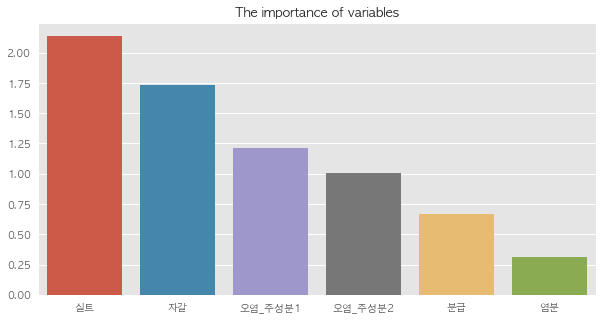

In [59]:
# 생성한 모델로 값 예측히기
y_pred = list(map(round, clf_model.predict(X_test)))

print('Accuracy Score :', accuracy_score(y_test, y_pred), '\n')
print('F1 Score :', f1_score(y_test, y_pred), '\n')

# 변수 중요도 데이터 프레임으로 생성
logit_importance = pd.DataFrame(pow(math.e, clf_model.params), columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 5))
sns.barplot(x = logit_importance.index, y = 'Importance', data = logit_importance)
plt.title('The importance of variables', fontsize = 13)
plt.ylabel('')
plt.show()

## 6. Clustering

- 위에서 최종적으로 선택한 5개의 변수를 사용하여 군집분석을 수행하도록 한다.


- 군집분석 수행 후, 각 군집의 특성이 어떠한지도 살펴보도록 하자.

In [109]:
# 군집분석에 사용할 데이터 저장
clu_data = eda_data[['id', '실트', '자갈', '분급', '염분', '오염_주성분1', 'target']].copy()

# Scaling을 위해 MaxAbsScaler 객체 생성
scaler = MaxAbsScaler()

# 5개의 변수에서 '오염_주성분1' 변수는 제외하고 Scaling을 수행해주어야 한다.
clu_data[['실트_scale', '자갈_scale', '분급_scale', '염분_scale']] = scaler.fit_transform(clu_data[['실트', '자갈', '분급', '염분']])

# 데이터 일부 확인
display(clu_data.head())

,id,실트,자갈,분급,염분,오염_주성분1,target,실트_scale,자갈_scale,분급_scale,염분_scale
0,316,53.767258,2.131936,2.241080,32.266284,-0.792560,0,0.672737,0.086704,0.580058,0.954202
1,317,52.496485,2.388136,2.224635,32.312201,-0.832183,0,0.656837,0.097123,0.575802,0.955560
2,401,35.540126,0.564265,1.634023,31.337345,-1.546873,0,0.444679,0.022948,0.422934,0.926731
3,402,36.376906,0.541554,1.744004,31.393658,-1.278618,0,0.455148,0.022024,0.451400,0.928396
4,403,35.998440,0.550979,1.816959,31.425321,-0.942646,0,0.450413,0.022408,0.470283,0.929333


In [110]:
# KMeans 객체 생성 후 학습시키기
kmeans = KMeans(n_clusters = 4, random_state = 0).fit(clu_data[['실트_scale', '자갈_scale', '분급_scale', '염분_scale', '오염_주성분1']])

# 각 관측치의 군집 번호 부여
clu_data['KMeans_cluster'] = kmeans.labels_

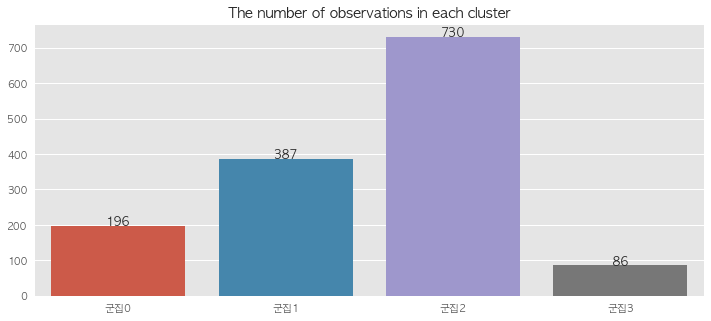

In [111]:
# 시각화를 통해 각 군집에 몇 개의 관측치가 있는지 확인
fig, axes = plt.subplots(figsize = (12, 5))

sns.countplot(x = 'KMeans_cluster', data = clu_data)
axes.set_xticklabels(labels = ['군집1', '군집2', '군집3', '군집4'])
axes.set_ylabel('')
axes.set_xlabel('')
axes.set_title('The number of observations in each cluster')

for rect in axes.patches:
    axes.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha = 'center', fontsize = 12)

fig.show()

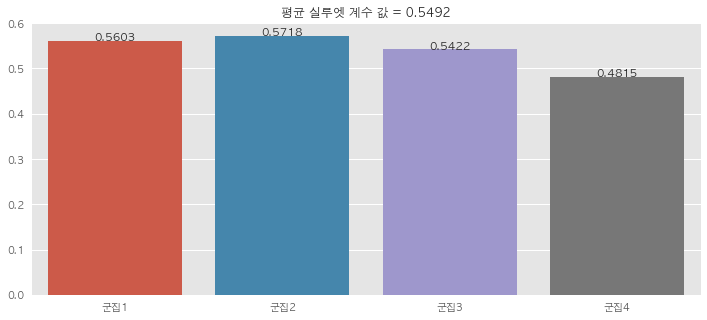

In [113]:
# 'silhouette_samples' 함수를 사용하여 각 관측치의 실루엣 계수 값 생성
clu_data['silhouette_coeff'] = silhouette_samples(clu_data[['실트_scale', '자갈_scale', '분급_scale', '염분_scale', '오염_주성분1']], clu_data['KMeans_cluster'])

# 평균 실루엣 계수 값 구하기
mean_silhouette = np.round(silhouette_score(clu_data[['실트_scale', '자갈_scale', '분급_scale', '염분_scale', '오염_주성분1']], clu_data['KMeans_cluster']), 4)

# 그룹별 실루엣 계수 값 시각화
plt.figure(figsize = (12, 5))
plot_data = pd.DataFrame(clu_data.groupby('KMeans_cluster')['silhouette_coeff'].mean())

sns.barplot(x = plot_data.index, y = 'silhouette_coeff', data = plot_data)
plt.title('평균 실루엣 계수 값 = {}'.format(mean_silhouette), fontsize = 12)
plt.xticks(ticks = [0, 1, 2, 3], labels = ['군집1', '군집2', '군집3', '군집4'])
plt.xlabel('')
plt.ylabel('')

for index, [value] in enumerate(np.round(plot_data.values, 4)):
    plt.text(index, value, value, ha = 'center', fontsize = 11)

plt.show()

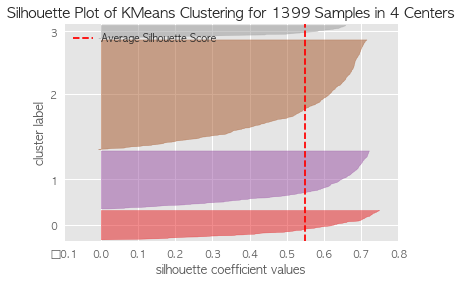

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1399 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [114]:
# yellowbrick 패키지를 사용하여 시각화
visualizer = SilhouetteVisualizer(KMeans(n_clusters = 4, random_state = 0))
visualizer.fit(clu_data[['실트_scale', '자갈_scale', '분급_scale', '염분_scale', '오염_주성분1']])
visualizer.show()

- K-Means 알고리즘을 사용하여 군집분석을 수행하였고 군집의 개수를 4개로 하였을 때, 실루엣 계수는 위의 그림과 같다.


- 실루엣 계수의 값이 1로 가까워질수록 근처 군집과 더 멀리 떨어져 있다는 것을 의미하므로, 해당 군집을 잘 분리된것으로 판단된다.


- 이제 각 군집에 대한 5개 변수의 특징을 살펴보도록 하자.

In [139]:
# 각 군집에 대해서 5개 변수의 평균 구하기
result_data = clu_data[['실트', '자갈', '분급', '염분', '오염_주성분1', 'KMeans_cluster', 'id', 'target']]

# 각 군집별 5개 변수 평균
pivot_data = pd.pivot_table(index = 'KMeans_cluster', data = result_data.iloc[:, :6], aggfunc = 'mean')

# 로지스틱 회귀분석 수행 후, 구해주었던 각 변수의 가중치를 곱해주기
for column in pivot_data.columns.tolist():
    
    # 'logit_importance' 데이터에서 해당 변수의 값 저장
    weight = logit_importance[logit_importance.index == column].values.flatten()
    
    # 해당 변수의 가중치를 곱하기
    pivot_data.loc[:, column] = pivot_data.loc[:, column] * weight

# 모든 변수에 가중치를 곱해주었으므로 5개 변수의 합을 구해 각 군집의 순위를 구한다.
pivot_data['rank'] = pivot_data.sum(axis = 1).rank(ascending = False).astype('int')
display(pivot_data.style.background_gradient(cmap = 'Blues'))

,분급,실트,염분,오염_주성분1,자갈,rank
KMeans_cluster,,,,,,
0,1.289156,113.584781,8.967432,3.136656,3.673997,2
1,1.673981,95.332594,9.888564,-2.353578,4.836634,4
2,1.480878,96.412408,9.762067,-0.302303,3.817002,3
3,1.131913,133.989990,8.985394,6.008507,1.022048,1


In [141]:
# 각 군집의 순위를 구했으므로 'result_data'에 rank 변수를 생성
result_data['rank'] = result_data['KMeans_cluster'].map({0 : 2, 1 : 4, 2 : 3, 3: 1})
display(result_data.head())

,실트,자갈,분급,염분,오염_주성분1,KMeans_cluster,id,target,rank
0,53.767258,2.131936,2.241080,32.266284,-0.792560,2,316,0,3
1,52.496485,2.388136,2.224635,32.312201,-0.832183,2,317,0,3
2,35.540126,0.564265,1.634023,31.337345,-1.546873,1,401,0,4
3,36.376906,0.541554,1.744004,31.393658,-1.278618,1,402,0,4
4,35.998440,0.550979,1.816959,31.425321,-0.942646,2,403,0,3


```python
result_data.to_csv(data_path + '/result_data.csv', encoding = 'CP949', index = False)
```